In [72]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sortedcontainers import SortedList
from sklearn.model_selection import train_test_split
import math

In [73]:
df = pd.read_csv('../dataset/rating_final1.csv')
movie_df = pd.read_csv('../dataset/movie_final.csv')
df = shuffle(df)

df_train, df_test = train_test_split(df)

In [74]:
user_to_movie = {}
movie_to_user = {}
movie_user_rating = {}
movie_user_rating_train = {}
movie_user_rating_test = {}

bias_movie = {}
bias_user = {}

for row in df.values:
    movie_id, user_id, rate = row
    if movie_id not in user_to_movie:
        user_to_movie[user_id] = [movie_id]
    else:
        user_to_movie[user_id].append(movie_id)
    
    if movie_id not in movie_to_user:
        movie_to_user[movie_id] = [user_id]
    else:
        movie_to_user[movie_id].append(user_id)

    movie_user_rating[(movie_id, user_id)] = rate

average = np.mean(list(movie_user_rating.values()))

for user_id in user_to_movie:
    rates = []
    for movie_id in user_to_movie[user_id]:
        rates.append(movie_user_rating[(movie_id, user_id)] - average)
    bias_user[user_id] = np.mean(rates)

for movie_id in movie_to_user:
    rates = []
    for user_id in movie_to_user[movie_id]:
        rates.append(movie_user_rating[(movie_id, user_id)] - average)
    bias_movie[movie_id] = np.mean(rates)

for row in df_train.values:
    movie_id, user_id, rate = row
    movie_user_rating_train[(movie_id, user_id)] = rate

for row in df_test.values:
    movie_id, user_id, rate = row
    movie_user_rating_test[(movie_id, user_id)] = rate

In [75]:
print(average)
print(bias_movie)
print(bias_user)

8.157629212514724
{'tt0087843': 0.07040109051557898, 'tt1375666': -0.21128774910008974, 'tt1649418': -1.6121746670601784, 'tt0029583': -0.6528163782901251, 'tt0031679': -0.17362921251472416, 'tt0106028': -0.24429587918139078, 'tt4016934': -0.13689750519765093, 'tt0111958': -0.3004863553718669, 'tt0089881': 0.14483384167246802, 'tt1488589': -0.6268599817454935, 'tt2119532': -0.09417743586497793, 'tt0278238': 0.12841729911318278, 'tt0086190': -0.020659515545026996, 'tt4729430': 0.1407834858979743, 'tt0108052': 0.8664671730274447, 'tt0363163': 0.23309926430646796, 'tt0317705': -0.10155444615958387, 'tt1205489': 0.1960941917405951, 'tt2013293': -0.4826292125147241, 'tt2582802': 0.38665123028970405, 'tt0264235': -0.18096254584805732, 'tt0068646': 0.8844760506431709, 'tt19623240': -1.8735383034238153, 'tt10272386': 0.297689936421446, 'tt8579674': 0.16786098356370724, 'tt0064116': 0.2709422160567045, 'tt0099685': 0.9045930097074982, 'tt0050083': 0.4621624541519426, 'tt0266697': 0.014870787485

In [76]:
number_of_movie = int(len(movie_to_user.keys()))
number_of_user = int(len(user_to_movie.keys()))

print(f'Number of movie: {number_of_movie}')
print(f'Number of user: {number_of_user}')

Number of movie: 490
Number of user: 997


In [77]:
# latent dimensionality
k = 30
W = dict.fromkeys(user_to_movie.keys())
U = dict.fromkeys(movie_to_user.keys())

In [78]:
print(len(W), len(U))

997 490


In [79]:
def evaluate():
    loss = 0
    for movie_id, user_id in movie_user_rating_test:
        rate = movie_user_rating_test[(movie_id, user_id)]
        error = rate - get_rating(user_id, movie_id)

        loss += error ** 2
    return (loss, math.sqrt(loss / len(movie_user_rating_test)))

def evaluate_with_bias():
    loss = 0
    for movie_id, user_id in movie_user_rating_test:
        rate = movie_user_rating_test[(movie_id, user_id)]
        error = rate - get_rating_with_bias(user_id, movie_id)

        loss += error ** 2
    return (loss, math.sqrt(loss / len(movie_user_rating_test)))

def evaluate_with_bias_and_content_based():
    loss = 0
    for movie_id, user_id in movie_user_rating_test:
        rate = movie_user_rating_test[(movie_id, user_id)]
        error = rate - get_rating_with_bias_content_based(user_id, movie_id)

        loss += error ** 2
    return (loss, math.sqrt(loss / len(movie_user_rating_test)))

def get_rating(user_id, movie_id):
    return np.dot(W[user_id], U[movie_id])

def get_rating_with_bias(user_id, movie_id):
    return np.dot(W[user_id], U[movie_id]) + average + bias_movie[movie_id] + bias_user[user_id]

def get_rating_with_bias_content_based(user_id, movie_id):
    movies = {}
    for row in movie_df.values:
        id, name, poster, directors, writers, genres, actors, releaseYear, limit, duration, language, origin = row
        movies[id] = {
            'name': name,
            'poster': poster,
            'directors': directors,
            'genres': genres,
            'actors': actors,
            'releaseYear': releaseYear,
            'limit': limit,
            'duration': duration,
            'writers': writers,
            'language': language,
            'origin': origin
        }

    def get_sim_director(movie_id_i, movie_id_j):
        director_i = set(movies[movie_id_i]['directors'])
        director_j = set(movies[movie_id_j]['directors'])

        return 0.125 * (len(director_i.intersection(director_j)) / len(director_i.union(director_j)))

    def get_sim_writer(movie_id_i, movie_id_j):
        writer_i = set(movies[movie_id_i]['writers'])
        writer_j = set(movies[movie_id_j]['writers'])

        return 0.125 * (len(writer_i.intersection(writer_j)) / len(writer_i.union(writer_j)))

    def get_sim_actor(movie_id_i, movie_id_j):
        actor_i = set(movies[movie_id_i]['actors'])
        actor_j = set(movies[movie_id_j]['actors'])

        return 0.125 * (len(actor_i.intersection(actor_j)) / len(actor_i.union(actor_j)))

    def get_sim_releaseYear(movie_id_i, movie_id_j):
        releaseYear_i = int(movies[movie_id_i]['releaseYear'])
        releaseYear_j = int(movies[movie_id_j]['releaseYear'])

        diff = abs(releaseYear_i - releaseYear_j)
        if diff < 3:
            return 0.05
        elif diff < 5:
            return 0.05 * 0.8
        elif diff < 10:
            return 0.05 * 0.5
        elif diff < 20:
            return 0.05 * 0.3
        return 0

    def get_sim_genres(movie_id_i, movie_id_j):
        genres_i = set(movies[movie_id_i]['genres'])
        genres_j = set(movies[movie_id_j]['genres'])

        return 0.35 * (len(genres_i.intersection(genres_j)) / len(genres_i.union(genres_j)))

    def get_sim_limit(movie_id_i, movie_id_j):
        limit_i = movies[movie_id_i]['limit']
        limit_j = movies[movie_id_j]['limit']
        if limit_i == limit_j:
            return 0.025
        return 0

    def get_sim_duration(movie_id_i, movie_id_j):
        global movie_df
        duration_i = float(movies[movie_id_i]['duration'])
        duration_j = float(movies[movie_id_j]['duration'])

        diff = abs(duration_i - duration_j)
        if diff < 15:
            return 0.125
        elif diff < 30:
            return 0.125 * 0.8
        elif diff < 60:
            return 0.125 * 0.6
        elif diff < 90:
            return 0.125 * 0.3
        return 0

    def get_sim_language(movie_id_i, movie_id_j):
        language_i = movies[movie_id_i]['language']
        language_j = movies[movie_id_j]['language']
        if language_i == language_j:
            return 0.05
        return 0

    def get_sim_origin(movie_id_i, movie_id_j):
        origin_i = movies[movie_id_i]['origin']
        origin_j = movies[movie_id_j]['origin']
        if origin_i == origin_j:
            return 0.025
        return 0

    def get_movie_similarities(movie_id_i, movie_id_j):
        sim_director = get_sim_director(movie_id_i, movie_id_i)
        sim_writer = get_sim_writer(movie_id_i, movie_id_j)
        sim_genre = get_sim_genres(movie_id_i, movie_id_j)
        sim_actor = get_sim_actor(movie_id_i, movie_id_j)
        sim_releaseYear = get_sim_releaseYear(movie_id_i, movie_id_j)
        sim_duration = get_sim_duration(movie_id_i, movie_id_j)
        sim_limit = get_sim_limit(movie_id_i, movie_id_j)
        sim_language = get_sim_language(movie_id_i, movie_id_j)
        sim_origin = get_sim_origin(movie_id_i, movie_id_j)

        return sim_director + sim_genre + sim_actor + sim_releaseYear + sim_duration + sim_limit + sim_writer + sim_language + sim_origin
    sim = []
    for movie_id_user_rated in user_to_movie[user_id]:
        sim.append(get_movie_similarities(movie_id_user_rated, movie_id))
    return np.mean(sim) * get_rating_with_bias(user_id, movie_id)

In [80]:
def dump():
    for user_id in W.keys():
        W[user_id] = np.random.randn(k)
    for movie_id in U.keys():
        U[movie_id] = np.random.randn(k)

def fit(epoch, learning_rate, weight, update_func, evaluate_func):
    losses_train = []
    losses_validation = []

    rmse_train = []
    rmse_validation = []

    dump()

    for i in range(0, epoch):
        loss = 0    
        
        for movie_id, user_id in movie_user_rating_train:
            loss += update_func((movie_id, user_id, learning_rate, weight))

        rmse = math.sqrt(loss / len(movie_user_rating_train))

        loss_test, rmse_test = evaluate_func()
        
        losses_train.append(loss)
        losses_validation.append(loss_test)

        rmse_train.append(rmse)
        rmse_validation.append(rmse_test)

        print(f'Epoch: {i + 1}/{epoch}')
        print('Loss: ' , loss, 'RMSE: ', rmse, 'Loss_Validation: ', loss_test, 'RMSE_Validation: ', rmse_test)

    x_axis = list(range(1, epoch + 1))
    fig, axis = plt.subplots(nrows = 1, ncols = 2)

    axis[0].plot(x_axis, losses_train, color = 'red', label = 'Loss Train')
    axis[0].set_xlabel('Epoch')
    axis[0].set_ylabel('Loss')

    axis[0].plot(x_axis, losses_validation, color = 'blue', label = 'Loss Test')
    axis[0].legend(loc = 'upper right')

    axis[1].plot(x_axis, rmse_train, color = 'red', label = 'RMSE Train')
    axis[1].set_xlabel('Epoch')
    axis[1].set_ylabel('RMSE')

    axis[1].plot(x_axis, rmse_validation, color = 'blue', label = 'RMSE Test')
    axis[1].legend(loc = 'upper right')
    plt.show()
    

In [81]:
def matrix_fact(args):
    movie_id, user_id, learning_rate, _ = args
    rate = movie_user_rating_train[(movie_id, user_id)]
    
    error = rate - np.dot(W[user_id], U[movie_id])
    
    saved_w = np.copy(W[user_id])
    saved_u = np.copy(U[movie_id])

    W[user_id] += 2 * learning_rate * error * saved_u
    U[movie_id] += 2 * learning_rate * error * saved_w

    return error ** 2

def matrix_fact_with_bias(args):
    global average

    movie_id, user_id, learning_rate, weight = args
    rate = movie_user_rating_train[(movie_id, user_id)]

    predict_rating = average + bias_movie[movie_id] + bias_user[user_id] + np.dot(W[user_id], U[movie_id])
    
    error = rate - predict_rating

    average = average + learning_rate * error

    bias_movie[movie_id] += learning_rate * (error - weight * bias_movie[movie_id])
    bias_user[user_id] += learning_rate * (error - weight * bias_user[user_id])
    
    saved_w = np.copy(W[user_id])
    saved_u = np.copy(U[movie_id])

    W[user_id] += learning_rate * (2 * error * saved_u - weight * saved_w)
    U[movie_id] += learning_rate * (2 * error * saved_w - weight * saved_u)

    return error ** 2

def matrix_fact_with_bias_and_content_based(args):
    global average

    movie_id, user_id, learning_rate, weight = args
    rate = movie_user_rating_train[(movie_id, user_id)]

    predict_rating = get_rating_with_bias_content_based(user_id, movie_id)
    
    error = rate - predict_rating

    average = average + learning_rate * error

    bias_movie[movie_id] += learning_rate * (error - weight * bias_movie[movie_id])
    bias_user[user_id] += learning_rate * (error - weight * bias_user[user_id])
    
    saved_w = np.copy(W[user_id])
    saved_u = np.copy(U[movie_id])

    W[user_id] += learning_rate * (2 * error * saved_u - weight * saved_w)
    U[movie_id] += learning_rate * (2 * error * saved_w - weight * saved_u)

    return error ** 2

def get_top_n(user_id, get_rating_func, n = 10):
    recommend_list = SortedList()
    for movie_id in movie_to_user.keys():
        if (movie_id, user_id) not in movie_user_rating:
            rating = get_rating_func(user_id, movie_id)
            recommend_list.add((rating, movie_id))
            if len(recommend_list) > n:
                del recommend_list[0]
    return recommend_list

In [82]:
# fit(100, 0.01, 0.2, matrix_fact, evaluate)

# get_top_n('ur156820301', get_rating)

Epoch: 1/100
Loss:  346714.61875500577 RMSE:  3.590661998917918 Loss_Validation:  59451.20463679614 RMSE_Validation:  2.4963538324298553
Epoch: 2/100
Loss:  69477.99468098856 RMSE:  1.6073560389667396 Loss_Validation:  47644.7206621994 RMSE_Validation:  2.2347719168064306
Epoch: 3/100
Loss:  47773.7989033326 RMSE:  1.3328563250838226 Loss_Validation:  42752.73070447177 RMSE_Validation:  2.116936067253263
Epoch: 4/100
Loss:  39974.93192178874 RMSE:  1.2192206651223434 Loss_Validation:  39806.95952954562 RMSE_Validation:  2.042703421265057
Epoch: 5/100
Loss:  35315.955005453805 RMSE:  1.145971787999552 Loss_Validation:  37802.20411325205 RMSE_Validation:  1.9906017155795757
Epoch: 6/100
Loss:  31999.298107060775 RMSE:  1.0908340224840964 Loss_Validation:  36343.90132911025 RMSE_Validation:  1.951828184807633
Epoch: 7/100
Loss:  29419.67208749683 RMSE:  1.0459414221438648 Loss_Validation:  35235.75832422732 RMSE_Validation:  1.9218417508545835
Epoch: 8/100
Loss:  27311.72592841329 RMSE:  

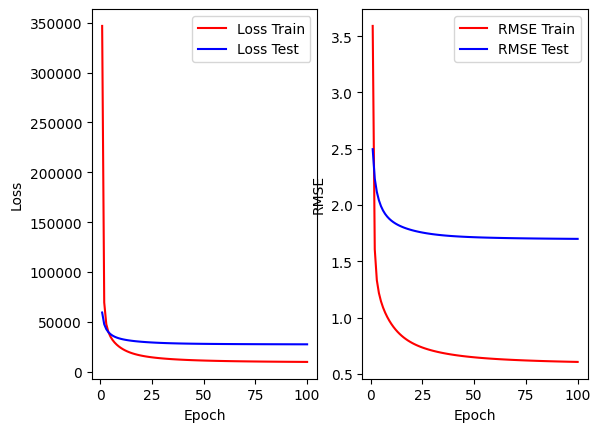

SortedList([(9.165836144490486, 'tt12343534'), (9.191167359142714, 'tt0944947'), (9.280072592111555, 'tt0266543'), (9.288884613532117, 'tt0468569'), (9.29753887082736, 'tt0098904'), (9.320657977647482, 'tt4269716'), (9.46131107511979, 'tt1606375'), (9.558635151823852, 'tt2401256'), (9.712393521568874, 'tt0121220'), (9.936091812933432, 'tt0268093')])

In [83]:
fit(100, 0.01, 0.2, matrix_fact_with_bias, evaluate_with_bias)

get_top_n('ur156820301', get_rating_with_bias)

In [84]:
# fit(100, 0.01, 0.2, matrix_fact_with_bias_and_content_based, evaluate_with_bias_and_content_based)